## Mount drive and import data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io, transform
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

plt.ion()

Check the mount.

In [3]:
dataDir = '/content/gdrive/My Drive/Colab Notebooks/pytorch-execises/faces'
!ls "{dataDir}"

0805personali01.jpg	   3298715079_5af7c78fcb.jpg
1084239450_e76e00b7e7.jpg  3325611505_ddc7beffa1.jpg
10comm-decarlo.jpg	   3362762930_24f76cb89c.jpg
110276240_bec305da91.jpg   343583208_e986824d77.jpg
1198_0_861.jpg		   3461016494_56cce9c984.jpg
137341995_e7c48e9a75.jpg   348272697_832ce65324.jpg
1383023626_8a49e4879a.jpg  3534188114_2108895291.jpg
144044282_87cf3ff76e.jpg   3534189272_8ef88ba368.jpg
152601997_ec6429a43c.jpg   3555944509_7b477069c6.jpg
1549040388_b99e9fa295.jpg  3574737496_6ee8207045.jpg
1878519279_f905d4f34e.jpg  362167809_d5a5dcbfdb.jpg
2046713398_91aaa6fe1c.jpg  363149951_8be04dc6c0.jpg
2173711035_dbd53b4f9f.jpg  3638950581_3387685d3a.jpg
2210514040_6b03ff2629.jpg  3646828311_bfeb429ef7.jpg
2322901504_08122b01ba.jpg  3689162471_5f9ffb5aa0.jpg
2327253037_66a61ea6fe.jpg  3718903026_c1bf5dfcf8.jpg
2328398005_d328a70b4c.jpg  3790616528_297c0ac935.jpg
2370961440_6bc8ce346c.jpg  3855944735_e252959937.jpg
2382SJ8.jpg		   3856149136_d4595ffdd4.jpg
252418361_440b75751b.jpg 

In [4]:
landmarksFrame = pd.read_csv(os.path.join(dataDir, 'face_landmarks.csv'))
print("DataFrame shape:", landmarksFrame.shape)
landmarksFrame.head()

DataFrame shape: (69, 137)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,part_4_y,part_5_x,part_5_y,part_6_x,part_6_y,part_7_x,part_7_y,part_8_x,part_8_y,part_9_x,part_9_y,part_10_x,part_10_y,part_11_x,part_11_y,part_12_x,part_12_y,part_13_x,part_13_y,part_14_x,part_14_y,part_15_x,part_15_y,part_16_x,part_16_y,part_17_x,part_17_y,part_18_x,part_18_y,part_19_x,...,part_48_x,part_48_y,part_49_x,part_49_y,part_50_x,part_50_y,part_51_x,part_51_y,part_52_x,part_52_y,part_53_x,part_53_y,part_54_x,part_54_y,part_55_x,part_55_y,part_56_x,part_56_y,part_57_x,part_57_y,part_58_x,part_58_y,part_59_x,part_59_y,part_60_x,part_60_y,part_61_x,part_61_y,part_62_x,part_62_y,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,139,49,150,60,159,73,166,87,168,100,166,111,160,120,151,128,141,133,128,137,116,138,102,138,89,44,70,53,66,63,...,71,137,78,131,85,127,90,129,94,129,99,134,103,142,97,144,92,145,88,145,83,144,77,141,75,137,85,134,89,135,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,320,100,340,111,359,126,375,149,379,175,376,197,364,218,346,236,322,249,296,254,266,256,237,256,207,65,210,69,197,80,...,110,314,117,310,126,308,135,309,147,307,164,306,184,307,167,317,152,321,139,323,130,322,120,318,114,313,127,312,136,313,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,169,80,180,91,189,103,195,115,197,128,197,139,192,148,184,154,173,160,162,164,150,169,138,171,126,80,101,87,95,98,...,101,163,109,157,117,155,123,157,129,156,134,160,139,168,133,171,126,172,120,172,114,171,107,168,104,162,116,161,122,162,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,220,89,238,108,255,129,268,155,268,180,261,203,244,222,224,238,199,247,172,248,144,245,116,241,87,39,114,45,102,57,...,98,207,107,199,120,193,131,193,142,188,162,185,184,187,168,206,151,218,139,222,127,223,113,219,103,206,122,203,133,201,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,536,186,567,214,594,249,614,290,616,329,608,363,589,390,562,411,529,421,491,425,450,425,409,423,370,162,345,178,330,200,...,228,514,246,502,264,495,278,499,292,495,315,502,341,511,318,530,297,538,281,539,266,537,248,529,239,513,265,507,278,509,293,507,331,511,294,516,279,518,265,516


## Inspect data

Each image has 68 landmark points.
`part_*_x` are the x coordinates, and `part_*_y` are the y coordinates.

Let's see an example.

In [5]:
n = 27
_imgName = landmarksFrame.iloc[n,0]
_landmarks = landmarksFrame.iloc[n,1:].as_matrix().astype(float).reshape(-1,2)

print('Image name:', _imgName)
print('Landmarks shape:', _landmarks.shape)

Image name: 2902760364_89c50bde40.jpg
Landmarks shape: (68, 2)


In [0]:
def showLandmarks(image, landmarks):
    """Show an image with its landmarks."""
    plt.imshow(image)
    plt.scatter(*landmarks.T, s=10, marker='.', c='r')
    # Pause a bit so that plots are updated.
    plt.pause(0.001)

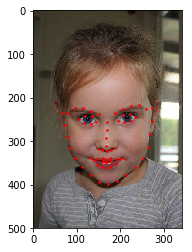

In [7]:
plt.figure()
showLandmarks(io.imread(os.path.join(dataDir, _imgName)),
              _landmarks)
plt.show()

## `Dataset` class

A custom `Dataset` class should realize:
- `__len__`
- `__getitem__`

We will read the csv in `__init__` and leave the image reading to `__getitem__` for the sake of memory efficiency.

In [0]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv, dataDir, transform=None):
        """
        Arguments
        ---------
        csv: str
        dataDir: str
        transform: callable
            Optional transformation to be applied on samples.
        """
        self.frame = pd.read_csv(os.path.join(dataDir, csv))
        self.dataDir = dataDir
        self.transform = transform

    def __len__(self):
        return len(self.frame)
    
    def __getitem__(self, idx):
        """Return a data as a dict with keys:
            'image'
            'landmarks'
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        path = os.path.join(self.dataDir,
                            self.frame.iloc[idx,0])
        image = io.imread(path)
        landmarks = self.frame.iloc[idx,1:].as_matrix()
        landmarks = landmarks.astype(float).reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if callable(self.transform):
            sample = self.transform(sample)
        
        return sample

Let's use this class to see first few examples.

0 (324, 215, 3) (68, 2)


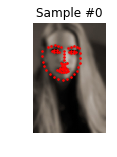

1 (500, 333, 3) (68, 2)


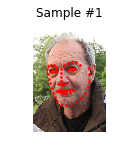

2 (250, 258, 3) (68, 2)


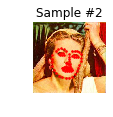

3 (434, 290, 3) (68, 2)


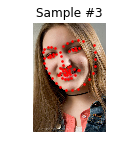

<Figure size 432x288 with 0 Axes>

In [9]:
dataset = FaceLandmarksDataset('face_landmarks.csv', dataDir)

fig = plt.figure()

for idx, sample in enumerate(dataset):
    print(idx, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, idx+1)
    ax.set_title(f'Sample #{idx}')
    ax.axis('off')
    showLandmarks(**sample)
    
    if idx == 3:
        plt.tight_layout()
        plt.show()
        break

## Transforms

We'll create 3 transform callables as classes rather than functions.
This allows us not to pass the required parameters everytime we call them.

In [0]:
class Rescale:
    def __init__(self, outSize):
        assert isinstance(outSize, (int, tuple))
        self.outSize = outSize
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        if isinstance(self.outSize, int):
            if h > w:
                newH, newW = self.outSize*h//w, self.outSize
            else:
                newH, newW = self.outSize, self.outSize*w//h
        else:
            newH, newW = self.outSize
            
        image = transform.resize(image, (newH, newW))
        
        # Note h and w are swapped:
        # for images, x is axis 1 and y is axis 0.
        landmarks = landmarks * [newW/w, newH/h]
        
        return {'image': image, 'landmarks': landmarks}

    
class RandomCrop:
    def __init__(self, outSize):
        assert isinstance(outSize, (int, tuple))
        if isinstance(outSize, int):
            self.outSize = (outSize, outSize)
        else:
            assert len(outSize) == 2
            self.outSize = outSize
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        h, w = image.shape[:2]
        newH, newW = self.outSize
        
        top = np.random.randint(0, h - newH)
        left = np.random.randint(0, w - newW)
        
        image = image[top:top+newH,
                      left:left+newW]
        landmarks = landmarks - [left, top]
        
        return {'image': image, 'landmarks': landmarks}
    
class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # Swap the axes:
        # numpy image: H, W, C
        # torch image: C, H, W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### Compose the transforms.

Let's rescale the shorter side of the images to 256 and then randomly crop 224^2 from them.
We'll use `torchvision.transforms.Compose` to compose our `Rescale` and `RandomCrop`.

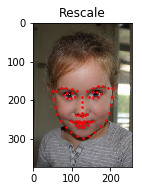

h: 500 , w: 342
top: 99 , left: 90


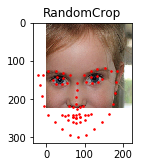

h: 374 , w: 256
top: 140 , left: 1


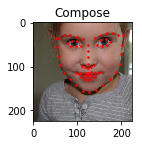

<Figure size 432x288 with 0 Axes>

In [11]:
scale = Rescale(256)
crop = RandomCrop(224)
composed = transforms.Compose([scale,crop])

# Apply each of the transforms above and compare.
fig = plt.figure()
sample = dataset[27]
for i, func in enumerate([scale, crop, composed]):
    transformed = func(sample)

    ax = plt.subplot(1, 3, i+1)
    ax.set_title(type(func).__name__)
    showLandmarks(**transformed)

plt.tight_layout()
plt.show()

## Iteration

We can directly iterate transformed data by instantiating `FaceLandmarksDataset` and iterating over it. However, then we're loosing

- Batching
- Shuffleing
- Parallel loading

So we'll use `torch.utils.data.DataLoader` to accomplish such. But let's first check the number of processors!

In [14]:
!nproc

2


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


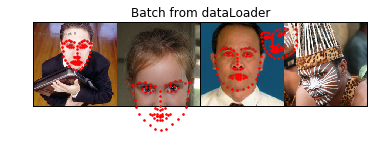

In [24]:
dataset = FaceLandmarksDataset('face_landmarks.csv',
                                dataDir,
                                transforms.Compose([
                                    Rescale(256),
                                    RandomCrop(224),
                                    ToTensor()
                                ])
                              )

dataLoader = DataLoader(dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=2)

def showBatch(batch):
    """Helper function to plot a batch."""
    imagesBatch = batch['image']
    landmarksBatch = batch['landmarks']
    batchSize = len(imagesBatch)
    imageSize = imagesBatch.size(2)
    gridBorderSize = 2
    
    grid = utils.make_grid(imagesBatch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batchSize):
        plt.scatter(landmarksBatch[i,:,0].numpy() + i*imageSize
                        + (i+1)*gridBorderSize,
                    landmarksBatch[i,:,1].numpy() + gridBorderSize,
                    s=10, marker='.', c='r')
        
        plt.title('Batch from dataLoader')

for i, batch in enumerate(dataLoader):
    print(i, batch['image'].shape, batch['landmarks'].shape)
    
    # See the 4th batch and halt.
    if i == 3:
        plt.figure()
        showBatch(batch)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## `torchvision`

`torchvision` provides commonly used datasets and transforms. One of the generic dataset classes is `ImageFolder`. And the available transforms include

- `RandomSizedCrop`
- `RandomHorizonalFlip`
- `ToTensor`
- `Normalize`

and so on.